In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
import fbprophet 
import sklearn.model_selection
import itertools
import sktime
import datetime
import collections

In [123]:
caiso_first_pass = pd.read_csv("interim/caiso_la_first_pass.csv",parse_dates=[['date', 'hour']])

In [4]:
load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * 1338

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

In [5]:
caiso_second_pass = load_data.set_index("date_hour").join(caiso_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]

In [6]:
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = caiso_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = caiso_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = caiso_second_pass.groupby(caiso_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(caiso_second_pass.groupby(caiso_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in caiso_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in caiso_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    caiso_second_pass[key] = dict_of_series[key]

In [53]:
load_data = pd.read_csv("data_release/ercot/ercot_houston_load.csv")

In [54]:
ercot_first_pass = pd.read_csv("interim/ercot_houston_first_pass.csv",parse_dates=[['date', 'hour']])

In [55]:
load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * len(dates)

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x,24 ) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

In [56]:
ercot_second_pass = load_data.set_index("date_hour").join(ercot_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]

In [57]:
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = ercot_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = ercot_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = ercot_second_pass.groupby(ercot_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(ercot_second_pass.groupby(ercot_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in ercot_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in ercot_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    ercot_second_pass[key] = dict_of_series[key]

In [58]:
ercot_second_pass

,date,hour,load,dwpc,relh,sped,tmpc,cum_avg_7_day_load,ewm_avg_7_day_load,max_24_hour_load,...,min_next_24_hour_tmpc,min_prev_24_hour_tmpc,mean_24_hour_tmpc,mean_next_24_hour_tmpc,mean_prev_24_hour_tmpc,weekday,weekend,pre_weekend,post_weekend,holiday
date_hour,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,00:00,8791.8,16.72,96.88,3.36,17.22,NaN,8791.800000,10583.5,...,14.39,NaN,19.594167,20.0675,NaN,6,1,0,0,0
2017-01-01 01:00:00,2017-01-01,01:00,8569.7,17.22,100.00,2.39,17.22,NaN,8789.187059,10583.5,...,14.39,NaN,19.594167,20.0675,NaN,6,1,0,0,0
2017-01-01 02:00:00,2017-01-01,02:00,8326.4,17.22,96.55,2.21,17.78,NaN,8783.742505,10583.5,...,14.39,NaN,19.594167,20.0675,NaN,6,1,0,0,0
2017-01-01 03:00:00,2017-01-01,03:00,8137.5,17.22,96.55,0.27,17.78,NaN,8776.139652,10583.5,...,14.39,NaN,19.594167,20.0675,NaN,6,1,0,0,0
2017-01-01 04:00:00,2017-01-01,04:00,8011.9,16.72,96.88,1.95,17.22,NaN,8767.148597,10583.5,...,14.39,NaN,19.594167,20.0675,NaN,6,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-29 19:00:00,2020-09-29,19:00,12566.5,3.28,26.08,5.40,23.89,12224.248553,12377.447885,13570.9,...,NaN,20.61,21.952083,NaN,24.26125,1,0,0,0,0
2020-09-29 20:00:00,2020-09-29,20:00,12112.7,6.11,36.25,1.24,21.72,12224.245155,12374.333204,13570.9,...,NaN,20.61,21.952083,NaN,24.26125,1,0,0,0,0
2020-09-29 21:00:00,2020-09-29,21:00,11459.8,8.89,46.92,0.18,20.61,12224.221870,12363.573990,13570.9,...,NaN,20.61,21.952083,NaN,24.26125,1,0,0,0,0


In [59]:
load_data = pd.read_csv("data_release/isone/isone_boston_load.csv")

isone_first_pass = pd.read_csv("interim/isone_boston_first_pass.csv",parse_dates=[['date', 'hour']])

load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * len(dates)

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x,24 ) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

isone_second_pass = load_data.set_index("date_hour").join(isone_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = isone_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = isone_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = isone_second_pass.groupby(isone_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(isone_second_pass.groupby(isone_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in isone_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in isone_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    isone_second_pass[key] = dict_of_series[key]

In [60]:
load_data = pd.read_csv("data_release/nyiso/nyiso_nyc_load.csv")

nyiso_first_pass = pd.read_csv("interim/nyiso_nyc_first_pass.csv",parse_dates=[['date', 'hour']])

load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * len(dates)

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x,24 ) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

nyiso_second_pass = load_data.set_index("date_hour").join(nyiso_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = nyiso_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = nyiso_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = nyiso_second_pass.groupby(nyiso_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(nyiso_second_pass.groupby(nyiso_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in nyiso_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in nyiso_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    nyiso_second_pass[key] = dict_of_series[key]

In [61]:
load_data = pd.read_csv("data_release/pjm/pjm_chicago_load.csv")

pjm_first_pass = pd.read_csv("interim/pjm_chicago_first_pass.csv",parse_dates=[['date', 'hour']])

load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * len(dates)

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x,24 ) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

pjm_second_pass = load_data.set_index("date_hour").join(pjm_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = pjm_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = pjm_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = pjm_second_pass.groupby(pjm_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(pjm_second_pass.groupby(pjm_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in pjm_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in pjm_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    pjm_second_pass[key] = dict_of_series[key]

In [62]:
load_data = pd.read_csv("data_release/spp/spp_kck_load.csv")

spp_first_pass = pd.read_csv("interim/spp_kck_first_pass.csv",parse_dates=[['date', 'hour']])

load_data.dropna(inplace=True)

load_data.reset_index(inplace=True)

dates = load_data.pop("date")

load_data.drop("index",1,inplace=True)

hour = np.ndarray.tolist(load_data.T.index.values) * len(dates)

load_data = pd.melt(load_data.T)

load_data["hour"] = hour

dates = list(itertools.chain.from_iterable(itertools.repeat(x,24 ) for x in dates))

load_data["variable"] = dates

load_data.rename(columns={"variable":"date"},inplace=True)

load_data.rename(columns={"value":"load"},inplace=True)

load_data["date_hour"] = pd.to_datetime(load_data["date"] + " " + load_data["hour"])

spp_second_pass = load_data.set_index("date_hour").join(spp_first_pass.set_index("date_hour"))[["date","hour","load","dwpc","relh","sped","tmpc"]]
dict_of_series = {}
for col in ["load","relh","dwpc","sped","tmpc"]:
    dict_of_series["cum_avg_7_day_" + col] = spp_second_pass[col].expanding(min_periods=7*24+1).mean()
    dict_of_series["ewm_avg_7_day_" + col] = spp_second_pass[col].ewm(span=169,adjust=False).mean()
    for i in ["max","min", "mean"]:
        dict_of_series[i + "_24_hour_" + col] = spp_second_pass.groupby(spp_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].repeat(24).values
        a = np.ndarray.tolist(spp_second_pass.groupby(spp_second_pass.index.date).agg({col:["min","max","mean"]})[col][i].values)
        b = a[1:]
        c = a[0:-1]
        b.append(np.nan)
        c.insert(0,np.nan)
        dict_of_series[i + "_next_24_hour_" + col] = np.repeat(b,24) 
        dict_of_series[i + "_prev_24_hour_" + col] = np.repeat(c,24)

weekdays = []
for item in spp_second_pass.index:
    weekdays.append(item.weekday())
dict_of_series["weekday"] = weekdays

weekend = []
pre_weekend = []
post_weekend = []
for item in weekdays:
    if item > 4:
        weekend.append(1)
    else:
        weekend.append(0)
    if item == 4:
        pre_weekend.append(1)
    else:
        pre_weekend.append(0)
    if item == 0:
        post_weekend.append(1)
    else:
        post_weekend.append(0)
dict_of_series["weekend"] = weekend
dict_of_series["pre_weekend"] = pre_weekend
dict_of_series["post_weekend"] = post_weekend

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dates[0], end=dates[-1]).to_pydatetime()
holiday_series = []
for item in spp_second_pass.index:
    if item in holidays:
        holiday_series.append(1)
    else:
        holiday_series.append(0)
dict_of_series["holiday"] = holiday_series

for key in dict_of_series.keys():
    spp_second_pass[key] = dict_of_series[key]

In [64]:
len(isone_second_pass), len(nyiso_second_pass), len(spp_second_pass), len(pjm_second_pass), len(ercot_second_pass), len(caiso_second_pass)

(32832, 32832, 32832, 32832, 32832, 32112)

In [65]:
isone_second_pass.to_csv("isone_boston_second_pass.csv")
nyiso_second_pass.to_csv("nyiso_nyc_second_pass.csv")
spp_second_pass.to_csv("spp_kck_second_pass.csv")
pjm_second_pass.to_csv("pjm_chicago_second_pass.csv")
ercot_second_pass.to_csv("ercot_houston_second_pass.csv")
caiso_second_pass.to_csv("caiso_la_second_pass.csv")

In [46]:
isone_second_pass

,date,hour,load,dwpc,relh,sped,tmpc,cum_avg_7_day_load,ewm_avg_7_day_load,max_24_hour_load,...,min_next_24_hour_tmpc,min_prev_24_hour_tmpc,mean_24_hour_tmpc,mean_next_24_hour_tmpc,mean_prev_24_hour_tmpc,weekday,weekend,pre_weekend,post_weekend,holiday
date_hour,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,00:00,2421.0,2.22,88.87,15.52,3.89,NaN,2421.000000,2960.4,...,-1.72,NaN,3.826667,2.380417,NaN,6,1,0,0,0
2017-01-01 01:00:00,2017-01-01,01:00,2335.1,1.72,89.53,16.10,3.28,NaN,2419.989412,2960.4,...,-1.72,NaN,3.826667,2.380417,NaN,6,1,0,0,0
2017-01-01 02:00:00,2017-01-01,02:00,2263.5,1.72,92.76,15.67,2.78,NaN,2418.148360,2960.4,...,-1.72,NaN,3.826667,2.380417,NaN,6,1,0,0,0
2017-01-01 03:00:00,2017-01-01,03:00,2217.0,1.72,92.76,15.52,2.78,NaN,2415.781909,2960.4,...,-1.72,NaN,3.826667,2.380417,NaN,6,1,0,0,0
2017-01-01 04:00:00,2017-01-01,04:00,2205.8,1.72,92.76,15.18,2.78,NaN,2413.311533,2960.4,...,-1.72,NaN,3.826667,2.380417,NaN,6,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-29 19:00:00,2020-09-29,19:00,3227.4,16.97,77.24,6.57,21.11,2731.334729,2604.364268,3293.6,...,NaN,17.78,20.488750,NaN,20.956667,1,0,0,0,0
2020-09-29 20:00:00,2020-09-29,20:00,3102.6,17.22,79.69,5.91,20.86,2731.346039,2610.225864,3293.6,...,NaN,17.78,20.488750,NaN,20.956667,1,0,0,0,0
2020-09-29 21:00:00,2020-09-29,21:00,2921.5,17.78,83.81,6.52,20.61,2731.351831,2613.887913,3293.6,...,NaN,17.78,20.488750,NaN,20.956667,1,0,0,0,0


In [68]:
caiso_load = pd.DataFrame(caiso_second_pass["load"])

In [141]:
tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=3)

In [142]:
for train_index, test_index  in tscv.split(caiso_load):
    X_train = caiso_load.iloc[train_index]
    X_test= caiso_load.iloc[test_index]

In [143]:
X_train

,load
date_hour,
2017-01-01 00:00:00,2956.0
2017-01-01 01:00:00,2865.0
2017-01-01 02:00:00,2757.0
2017-01-01 03:00:00,2675.0
2017-01-01 04:00:00,2604.0
...,...
2019-10-27 07:00:00,2298.0
2019-10-27 08:00:00,2320.0
2019-10-27 09:00:00,2421.0


In [144]:
X_train.rename(columns={"load":"y"},inplace=True)


C:\Users\princ\Anaconda3\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [145]:
X_train["ds"] = X_train.index

C:\Users\princ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [146]:
X_train.reset_index(drop=True,inplace=True)

In [147]:
model = Prophet(interval_width = 0.95,
yearly_seasonality = True,
weekly_seasonality = True,
daily_seasonality = True,
holidays = None,
changepoint_prior_scale = 0.05
)

In [148]:
model.fit(X_train)

In [149]:
future = model.make_future_dataframe(freq="H",periods= 24*30*11,include_history=False)
future = model.predict(future)

In [150]:
future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-27 12:00:00,3042.625675,2346.489730,3757.706004,3042.625675,3042.625675,-4.141858,-4.141858,-4.141858,197.394316,...,-291.759802,-291.759802,-291.759802,90.223628,90.223628,90.223628,0.0,0.0,0.0,3038.483816
1,2019-10-27 13:00:00,3042.615687,2480.689978,3800.203273,3042.615687,3042.615687,93.905683,93.905683,93.905683,287.708624,...,-283.484228,-283.484228,-283.484228,89.681287,89.681287,89.681287,0.0,0.0,0.0,3136.521369
2,2019-10-27 14:00:00,3042.605698,2499.310530,3926.597699,3042.605698,3042.605698,192.658990,192.658990,192.658990,377.642421,...,-274.118234,-274.118234,-274.118234,89.134803,89.134803,89.134803,0.0,0.0,0.0,3235.264688
3,2019-10-27 15:00:00,3042.595710,2646.330951,3995.349065,3042.595710,3042.595710,284.401767,284.401767,284.401767,459.542541,...,-263.724963,-263.724963,-263.724963,88.584189,88.584189,88.584189,0.0,0.0,0.0,3326.997478
4,2019-10-27 16:00:00,3042.585722,2739.335302,4066.000732,3042.585722,3042.585722,359.940499,359.940499,359.940499,524.285866,...,-252.374825,-252.374825,-252.374825,88.029457,88.029457,88.029457,0.0,0.0,0.0,3402.526221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,2020-09-21 07:00:00,2963.570258,-2389.766109,8121.975131,-2204.134523,8261.681284,-235.227246,-235.227246,-235.227246,-468.780160,...,-28.359116,-28.359116,-28.359116,261.912029,261.912029,261.912029,0.0,0.0,0.0,2728.343012
7916,2020-09-21 08:00:00,2963.560270,-2166.910252,8195.297200,-2204.500850,8262.363228,-55.438339,-55.438339,-55.438339,-301.628836,...,-14.115005,-14.115005,-14.115005,260.305503,260.305503,260.305503,0.0,0.0,0.0,2908.121932
7917,2020-09-21 09:00:00,2963.550282,-1899.776474,8408.357202,-2204.867177,8263.045172,117.927743,117.927743,117.927743,-140.340087,...,-0.433204,-0.433204,-0.433204,258.701034,258.701034,258.701034,0.0,0.0,0.0,3081.478025
7918,2020-09-21 10:00:00,2963.540294,-1692.141427,8308.862724,-2205.233503,8263.727115,265.299573,265.299573,265.299573,-4.424729,...,12.625647,12.625647,12.625647,257.098656,257.098656,257.098656,0.0,0.0,0.0,3228.839868


Text(0.5, 1.0, 'Training Data with Forecast and Test Data')

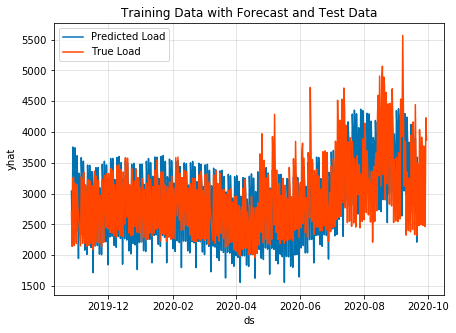

In [259]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()

fbprophet.plot.plot_forecast_component(model, future.iloc[::16,:],uncertainty=False,name="yhat",ax=ax)
plt.plot(X_test.iloc[::16,:].index, X_test.iloc[::16,:]["load"],"orangered",label="True Load")
plt.legend(("Predicted Load","True Load"))
plt.title("Training Data with Forecast and Test Data")


In [153]:
cv_results = cross_validation(model,initial="12112 hours",period= "3200 hours",horizon="3200 hours")

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-09-22 11:00:00 and 2019-06-16 03:00:00


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "C:\Users\princ\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-153-2c18790831aa>", line 1, in <module>
    cv_results = cross_validation(model,initial="12112 hours",period= "3200 hours",horizon="3200 hours")
  File "C:\Users\princ\Anaconda3\lib\site-packages\fbprophet\diagnostics.py", line 189, in cross_validation
    for cutoff in tqdm(cutoffs)
  File "C:\Users\princ\Anaconda3\lib\site-packages\fbprophet\diagnostics.py", line 189, in <listcomp>
    for cutoff in tqdm(cutoffs)
  File "C:\Users\princ\Anaconda3\lib\site-packages\fbprophet\diagnostics.py", line 227, in single_cutoff_forecast
    m.fit(history_c, **model.fit_kwargs)
  File "C:\Users\princ\Anaconda3\lib\site-packages\fbprophet\forecaster.py", line 1166, in fit
    self.params = self.stan_backend.fit(stan_init, dat, **kwargs)
  File "C:\Users\princ\Anaconda3\lib\site-pa

KeyboardInterrupt: 

In [155]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-07-11 00:00:00,3605.664634,3162.579274,4056.097151,4195.0,2018-07-09 15:00:00
1,2018-07-11 01:00:00,3386.532324,2959.963781,3852.302581,3834.0,2018-07-09 15:00:00
2,2018-07-11 02:00:00,3218.584206,2795.685970,3669.046018,3543.0,2018-07-09 15:00:00
3,2018-07-11 03:00:00,3117.902250,2690.740916,3548.743324,3335.0,2018-07-09 15:00:00
4,2018-07-11 04:00:00,3089.545585,2651.510860,3561.794131,3188.0,2018-07-09 15:00:00


In [156]:
performance_metrics(cv_results)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 12:00:00,233956.522208,483.690523,341.768410,0.095737,0.068339,0.731818
1,1 days 13:00:00,230725.413637,480.338853,338.548631,0.095384,0.068339,0.737879
2,1 days 14:00:00,226624.328779,476.050763,335.247763,0.095218,0.067906,0.743939
3,1 days 15:00:00,223791.647665,473.066219,333.271046,0.095340,0.069498,0.750000
4,1 days 16:00:00,223125.006331,472.361097,333.320519,0.095856,0.069498,0.756061
...,...,...,...,...,...,...,...
280,13 days 04:00:00,331443.689174,575.711463,404.550822,0.109696,0.089483,0.712338
281,13 days 05:00:00,337093.076590,580.597172,405.675736,0.108696,0.089368,0.712338
282,13 days 06:00:00,336233.822242,579.856726,403.070948,0.107237,0.088495,0.712338
283,13 days 07:00:00,328623.677860,573.257078,398.866495,0.106155,0.085459,0.712338


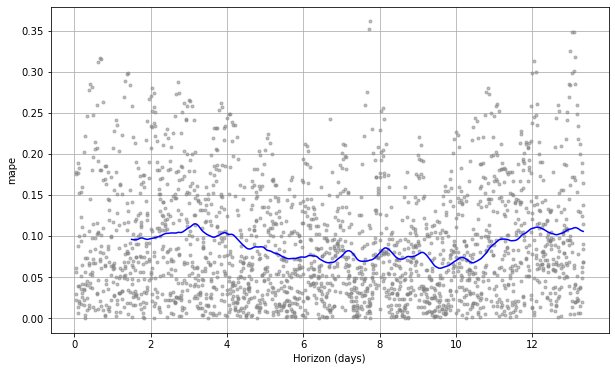

In [158]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')

In [28]:
values = []
for i in caiso_first_pass.columns:
    if i == "date":
        continue
    a = caiso_first_pass.rename(columns={"date":"ds", i:"y" })
    print(a.columns)
    values.append(a)

Index(['ds', 'y', 'dwpc', 'relh', 'sped', 'tmpc'], dtype='object')
Index(['ds', 'hour', 'y', 'relh', 'sped', 'tmpc'], dtype='object')
Index(['ds', 'hour', 'dwpc', 'y', 'sped', 'tmpc'], dtype='object')
Index(['ds', 'hour', 'dwpc', 'relh', 'y', 'tmpc'], dtype='object')
Index(['ds', 'hour', 'dwpc', 'relh', 'sped', 'y'], dtype='object')


In [29]:
def run_prophet(timeserie):
    model = Prophet()
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=90, include_history=False)
    forecast = model.predict(forecast)
    return forecast